# Advanced GeoPandas and Plotting
February 8, 2019  
David Shean

## Objectives
* Continue to explore GeoPandas functionality, including spatial joins
* Explore geospatial hexbin plots

Let's use the ICESat GLAS dataset one final time.  The first problem was one of the extra credit problems from Week 04.  It covers some fundamental concepts (like spatial and attribute joins), so work through it if haven't already.

## Background

https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

In [1]:
#%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
plt.rcParams['figure.figsize'] = [10, 8]

## Read in the gpkg of reprojected points that you saved last week

In [2]:
utm_fn='../04_Fundamentals_CRS_Geom/conus_glas_utm_32611.gpkg'
glas_gdf_utm = gpd.read_file(utm_fn)
utm_crs=glas_gdf_utm.crs
print(utm_crs)

{'init': 'epsg:32611'}


## Read in the state polygons

In [3]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf_utm = states_gdf.to_crs(utm_crs)

# Aggregate GLAS points by state polygons

Here's a summary of the steps:
* Compute number of points and mean elevation
* Generate cloropleth maps for both
* Note: the steps here are the solution I came up with.  If you can figure out a more efficient way to do it, I'd love to hear about it.

## Start with a spatial join between the glas_gdf_utm points and states_gdf_utm polygons
* http://geopandas.org/mergingdata.html
* http://geopandas.org/reference/geopandas.sjoin.html
* Consider limiting your GLAS GeoDataFrame to the ['glas_z', 'geometry'] columns and states GDF to ['NAME', 'geometry']
* Experiment with a few different operations (`op`) for the spatial join (e.g., `intersects`) and review the output with `head()`
    * Descriptions of different operations are here: https://shapely.readthedocs.io/en/stable/manual.html#object.intersects
        * Note that for our input spatial join of points and polygons, some of the details are irrelevant
    * Do you notice a difference in the output number of records?
* Choose the `how` keyword appropriately:
    * Test a few options and note the output number of records
    * Are there any points that don't fall within a state polygon?  Why might this be?  Do you want to preserve these moving forward?

In [4]:
#'right' here will preserve State geom, but adds records for each state
#glas_gdf_utm_states = gpd.sjoin(glas_gdf_utm[['glas_z', 'geometry']], states_gdf_utm[['NAME','geometry']], op='intersects', how='right')
#'left' preserves point geom
#glas_gdf_utm_states = gpd.sjoin(glas_gdf_utm[['glas_z', 'geometry']], states_gdf_utm[['NAME','geometry']], op='intersects', how='left')
#'inner' preserves point geom and drops any points that don't fall within a state (what we want)
glas_gdf_utm_states = gpd.sjoin(glas_gdf_utm[['glas_z', 'geometry']], states_gdf_utm[['NAME','geometry']], op='intersects', how='inner')

## Sanity check
* There should be a new column with corresponding state name listed for each point
* Check the joined gdf shape - does the number of records equal the original number of GLAS points?  Why or why not?

In [5]:
glas_gdf_utm_states.head()

,glas_z,geometry,index_right,NAME
0,1398.51,POINT (1431183.069745451 4955789.786789796),50,Wyoming
1,1387.11,POINT (1431181.914650238 4954913.88229024),50,Wyoming
2,1392.83,POINT (1431181.639258059 4954738.854527334),50,Wyoming
3,1384.24,POINT (1431181.393744648 4954563.604482028),50,Wyoming
4,1369.21,POINT (1431181.226227158 4954388.36587402),50,Wyoming


In [6]:
glas_gdf_utm_states.shape

(63850, 4)

In [7]:
glas_gdf_utm_states['NAME'].value_counts()

California    13865
Nevada        12081
Colorado       8429
Idaho          7297
Wyoming        5708
Utah           5498
Washington     5265
Oregon         2838
Montana        2658
New Mexico      209
Arizona           2
Name: NAME, dtype: int64

In [8]:
#Number of points that don't intersect state polygons
glas_gdf_utm_states['NAME'].isnull().sum()

0

In [9]:
glas_gdf_utm_states['NAME'].value_counts().sum()

63850

## Now aggregate by state name
* Note: the GeoPandas doc example uses a `dissolve` operation here, which is a wrapper around the `groupby` and `agg` Pandas functions
* But look at the geometry for the points - a bunch of duplicate state polygons.  So `dissolve` would recompute the union between identical geometries for the 1000s of points in each State.  Pretty inefficient.
* Try a standard Pandas `groupby` state name and then `agg` with `['count', 'mean']` to compute both simultaneously for your 'glas_z' values

In [10]:
#Dissolve points - inefficient
#glas_gdf_utm_states_dissolve = glas_gdf_utm_states.dissolve(by='NAME', aggfunc=['count', 'mean'])

In [11]:
glas_gdf_utm_states_count = glas_gdf_utm_states.groupby('NAME').agg(['count', 'mean'])['glas_z']

## Sanity check
* That was fast
* Since `groupby` and `agg` are Pandas operation, you should have a new Pandas DataFrame of state names with count and mean columns
    * Depending on how you did your spatial join, you could have some states with point count of 0 and mean of NaN.  If so, remove these states.

In [12]:
glas_gdf_utm_states_count

,count,mean
NAME,,
Arizona,2,1355.220000
California,13865,1701.699116
Colorado,8429,3253.791521
Idaho,7297,1790.290550
Montana,2658,2125.944759
Nevada,12081,1335.431521
New Mexico,209,1835.156699
Oregon,2838,1500.335525
Utah,5498,1439.914989


## Check the sum of your new count column
* Does it match the total point count in your input GLAS file?

In [13]:
glas_gdf_utm_states_count.sum()

count    63850.000000
mean     19668.401617
dtype: float64

## OK great, but the state geometry is gone!  How am I going to plot this?
* No sweat, we can use Pandas `merge` to do an attribute join on the state `'NAME'` values
* We can add the count and mean to our original state GeoDataFrame (should be UTM)
    * Careful here about merging on the GeoDataFrame vs. your aggregated DataFrame with count and mean values.
    * Depending on the way you merge, you may need to create a new GeoDataFrame from the output and define the crs appropriately

In [14]:
#This requires extra step
#glas_gdf_utm_states_count_merge = glas_gdf_utm_states_count.merge(states_gdf_utm[['NAME','geometry']], left_index=True, right_on='NAME')
#glas_gdf_utm_states_count_merge = gpd.GeoDataFrame(glas_gdf_utm_states_count_merge, crs=utm_crs)

#Merging on the gdf rather than df preserves geom and crs
glas_gdf_utm_states_count_merge = states_gdf_utm[['NAME','geometry']].merge(glas_gdf_utm_states_count, right_index=True, left_on='NAME')

In [15]:
glas_gdf_utm_states_count_merge

,NAME,geometry,count,mean
2,Arizona,"POLYGON ((897066.3554176949 4104261.564058403,...",2,1355.220000
4,California,(POLYGON ((22996.48140708072 4205264.970087427...,13865,1701.699116
5,Colorado,"POLYGON ((1409860.973618587 4595158.790561567,...",8429,3253.791521
12,Idaho,"POLYGON ((985353.812614471 4780284.452065009, ...",7297,1790.290550
26,Montana,"POLYGON ((1442716.652647813 5053084.210358191,...",2658,2125.944759
28,Nevada,"POLYGON ((748775.9930318886 4542963.704304956,...",12081,1335.431521
31,New Mexico,"POLYGON ((1541980.336069617 3594115.670319517,...",209,1835.156699
37,Oregon,"POLYGON ((116468.101118342 5066854.259479816, ...",2838,1500.335525
44,Utah,"POLYGON ((998902.2121082917 4583824.284407451,...",5498,1439.914989
47,Washington,(POLYGON ((90639.48402178317 5363086.831212449...,5265,1224.196596


## Create a cloropleth map to visualize these counts

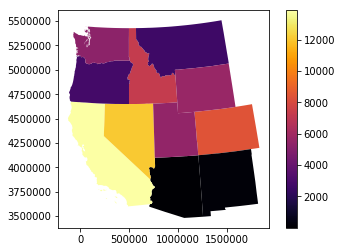

In [16]:
glas_gdf_utm_states_count_merge.plot('count', legend=True, cmap='inferno')

## Create a cloropleth map to visualize the mean elevation of all GLAS points in each state

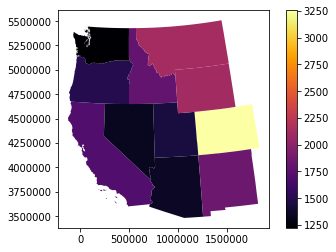

In [17]:
glas_gdf_utm_states_count_merge.plot('mean', legend=True, cmap='inferno')

# Create a hexbin plot to show point density in regularly spaced grid cells


## First, reproject the points to an equal-area projection
* Define a custom Albers Equal Area proj string `'+proj=aea...'`
    * https://en.wikipedia.org/wiki/Albers_projection
    * https://proj4.org/operations/projections/aea.html
    * Here is an aea proj string example for the USA (note that this uses GRS80 ellipsoid and NAD83 datum): http://spatialreference.org/ref/esri/102003/proj4/
        * Please create your own string using the WGS84 ellipsoid (see the proj4 doc for aea in the above link)
* Use the GLAS point total_bounds (in lat/lon) to compute a center longitude and center latitude for your projection (You did this in Lab #04)
* Define the two standard parallels (lines of latitude) based on the range of your points
    * Scale is true along these parallels, and distortion increases the further you go from these two parallels, it's important to choose appropriately
    * One approach would be to use min and max point latitude, but this could lead to additional distortion near the center latitude.
    * Could also place them slightly inside your min and max point latitude
* Use string formatting to create your proj string (don't just hardcode your values, but substitute variables in the string)
* Print the final proj string

In [18]:
#ll = glas_gdf.total_bounds
ll = np.array([-124.482406,   34.999455, -104.052336,   48.999727])
print(ll)
c = (ll[[0,2]].mean(), ll[[1,3]].mean())
p = ll[[1,3]].ptp()*0.67
p1 = c[1] - p/2.
p2 = c[1] + p/2.
#proj_str = '+proj=aea +lat_1=%0.2f +lat_2=%0.2f +lat_0=%0.2f +lon_0=%0.2f +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs ' % (p1, p2, c[1], c[0])
proj_str_aea = '+proj=aea +lat_1={:.2f} +lat_2={:.2f} +lat_0={:.2f} +lon_0={:.2f} +ellps=WGS84 +units=m +no_defs'.format(p1, p2, c[1], c[0])
print(proj_str_aea)

[-124.482406   34.999455 -104.052336   48.999727]
+proj=aea +lat_1=37.31 +lat_2=46.69 +lat_0=42.00 +lon_0=-114.27 +ellps=WGS84 +units=m +no_defs


## Define a transverse mercator projection (not UTM) with the same center longitude as your AEA projection
* https://proj4.org/operations/projections/tmerc.html
* Use center latitude of 0, similar to UTM
* Print your final proj string

In [19]:
proj_str_tmerc = '+proj=tmerc +lon_0={:.2f} +ellps=WGS84 +units=m +no_defs'.format(c[0])
print(proj_str_tmerc)

+proj=tmerc +lon_0=-114.27 +ellps=WGS84 +units=m +no_defs


## Create scatter plots for the GLAS points in your original UTM, custom AEA, and custom transverse mercator projections

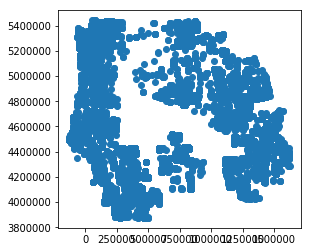

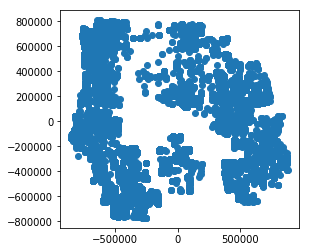

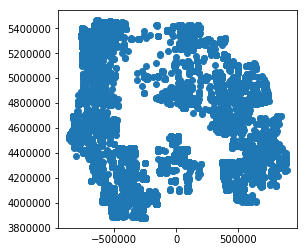

In [20]:
glas_gdf_utm.plot()
#proj_str='+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs '
glas_gdf_aea = glas_gdf_utm.to_crs(proj_str_aea)
glas_gdf_aea.plot()
glas_gdf_tmerc = glas_gdf_utm.to_crs(proj_str_tmerc)
glas_gdf_tmerc.plot()

## Umm, they look the same.  Why am I wasting time on this?

* Note the location of the origin for each coordinate system
    * The (0,0) should be near the center of your points for the AEA projection
    * Depending on which UTM zone you chose, your 0 could be near the west coast (UTM 10N) or maybe farther east if you chose UTM 11N

## Compare the total distance in meters between the min and max GLAS point coordinates (both x and y) for the AEA and your custom tmerc projection
* What do you expect?  Should they be equal?
    * Hint: are these equidistant projections?
* Use the GeoDataFrame total_bounds method here, then difference appropriately
* What is the percent difference in the x and y direction?
    * Are the equal?  Any ideas about why or why not?
    * Hint: think about distortion of transverse mercator projections in the y direction along the center longitude and in the x direction with distance from the center longitude
        * https://en.wikipedia.org/wiki/Transverse_Mercator_projection

In [21]:
#utm_bounds = glas_gdf_utm.total_bounds
utm_bounds = glas_gdf_tmerc.total_bounds
aea_bounds = glas_gdf_aea.total_bounds

In [26]:
utm_x_diff = np.diff(utm_bounds[::2])
aea_x_diff = np.diff(aea_bounds[::2])
utm_y_diff = np.diff(utm_bounds[1::2])
aea_y_diff = np.diff(aea_bounds[1::2])
print(utm_x_diff - aea_x_diff)
print(utm_y_diff - aea_y_diff)
print(100*np.abs(utm_x_diff - aea_x_diff)/utm_x_diff)
print(100*np.abs(utm_y_diff - aea_y_diff)/utm_y_diff)

[9031.93426378]
[3701.60564083]
[0.51794966]
[0.23355017]


## Check the area difference of the convex hulls
* Note: you'll want to use the GeoDataFrame unary_union method to aggregate the points as a MULTIPOINT object, then compute the convex_hull and area (can do this in one line for each GeoDataFrame)
* Compute the percent difference

In [23]:
aea_area = glas_gdf_aea.unary_union.convex_hull.area
utm_area = glas_gdf_utm.unary_union.convex_hull.area

In [24]:
100*np.abs(aea_area - utm_area)/aea_area

0.5552600833652925

## So what is going on here?
* You are seeing different types of distortion (distance, area, azimuth) for the different projections.
* It's important to pick a projection that is well-suited for your application.  If you care about accurate distance measurements (e.g., distances between points), you sould use an equidistant projection.  If you care about accurate area calculations, use an equal-area projection.  

## Extra Credit: Reproject your points into an equidistant projection and compare with the AEA and tmerc projections
* Repeat the above analysis

# Hexbin plots
* Hopefully the above got you thinking about projections again.  An equal-area projection is a good idea for a hexbin plot, so use your AEA points here.
* Hexbin plots are great for visualizing spatial distribution of point density
* Here are some resources:
    * https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hexbin.html
    * http://darribas.org/gds15/content/labs/lab_09.html
* Create a hexbin that shows the number of points in each cell
    * Play around with the `gridsize` option (or specify the dimensions of your bins) appropriately
    * Use the `mincnt` option to avoid plotting cells with 0 count
    * Overlay the state polygons to help visualize
    * Tweak your xlim and ylim to the GLAS point bounds
    * Can use linear color ramp with vmin and vmax options, or try a 'log' color ramp, since we have a broad range of counts
* Create a second hexbin plot that shows the median elevation in each bin
    * See documentation for the `C` and `reduce_C_function` options

(-772261.0866023188, 808966.8211379815)

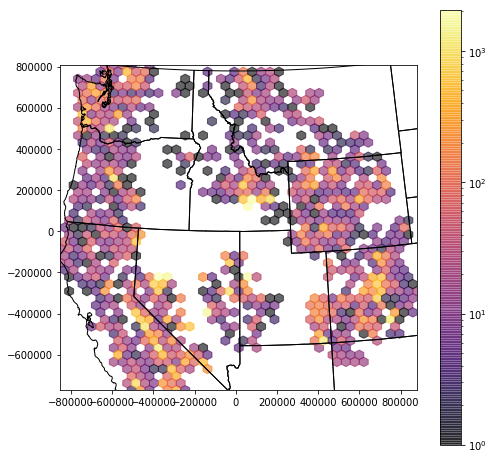

In [27]:
f,ax = plt.subplots(figsize=(8,8))
hb=ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, gridsize=40, cmap='inferno', bins='log', alpha=0.6, mincnt=1)
#hb=ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, gridsize=40, cmap='inferno', alpha=0.6, mincnt=1, vmin=0, vmax=200)
#hb=ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, C=glas_gdf_aea['glas_z'], reduce_C_function=np.median, gridsize=40, cmap='inferno', alpha=0.6)#, vmin=0, vmax=100)
states_gdf.to_crs(proj_str_aea).plot(ax=ax, facecolor='none', edgecolor='black')
plt.colorbar(hb)
ax.set_aspect('equal')
aea_bounds = glas_gdf_aea.total_bounds
ax.set_xlim(aea_bounds[[0,2]])
ax.set_ylim(aea_bounds[[1,3]])

(-772261.0866023188, 808966.8211379815)

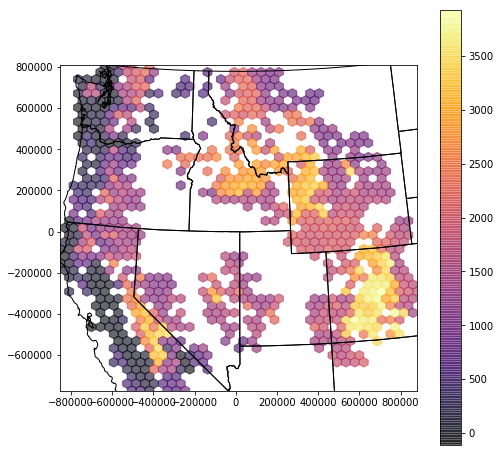

In [28]:
f,ax = plt.subplots(figsize=(8,8))
#hb=ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, gridsize=50, cmap='inferno', alpha=0.6, mincnt=1, vmin=0, vmax=100)
hb=ax.hexbin(glas_gdf_aea.geometry.x, glas_gdf_aea.geometry.y, C=glas_gdf_aea['glas_z'], reduce_C_function=np.median, gridsize=40, cmap='inferno', alpha=0.6)#, vmin=0, vmax=100)
states_gdf.to_crs(proj_str_aea).plot(ax=ax, facecolor='none', edgecolor='black')
plt.colorbar(hb)
ax.set_aspect('equal')
aea_bounds = glas_gdf_aea.total_bounds
ax.set_xlim(aea_bounds[[0,2]])
ax.set_ylim(aea_bounds[[1,3]])